# Quantitative Metrics of Time-Series Benchmark

## Data Extraction / Preparation

In [196]:
import wandb

# Initialize API (make sure you're logged in or set the API key)
wandb.login()

# Replace with your entity, project, and run ID
api = wandb.Api()

# Get all runs of the project that didn't crash
runs = api.runs(
    "rl-sunflower/tabpfn-time-series",
    # filters={"$and": [{"state": "finished"}, {"group": {"$in": ["11546127", "11548929"]}}]}
    filters={"group": {"$in": [
        "11632837",     # Seasonal Naive
        # "11549116",     # Vanilla TabPFN
        "11632923",     # Autogluon (without Chronos)
    ]}},   
)


In [197]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd

def fetch_run_data(run):
    history = run.history()
    
    if len(history) > 1:
        # get the first row
        history = history.iloc[-1:]
    return history

# time the following code
import time
start = time.time()

all_runs_data = []
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust 'max_workers' based on your network conditions
    futures = [executor.submit(fetch_run_data, run) for run in runs]
    for future in tqdm(as_completed(futures), total=len(futures)):
        all_runs_data.append(future.result())

df_all_runs = pd.concat(all_runs_data)
print("df_all_runs.shape:", df_all_runs.shape)

print(f"Time taken: {time.time() - start:.2f} seconds")

100%|██████████| 50/50 [00:05<00:00,  9.76it/s]


df_all_runs.shape: (50, 27)
Time taken: 6.00 seconds


In [198]:
# Preprocess data (convert to float, NaN value -> inf)
numerical_cols = ['mase', 'wql', 'duration', 'result']
for col in numerical_cols:
    df_all_runs[col] = df_all_runs[col].astype(float)
    df_all_runs[col] = df_all_runs[col].fillna(float('inf'))

In [199]:
# tabpfn_runs = df_all_runs[df_all_runs["framework"] == "TabPFN"]
df_sorted = df_all_runs.sort_values(by='task')

# drop index
df_sorted.reset_index(drop=True, inplace=True)

## Plotting

### Utils Function

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data, title, xlabel, ylabel, annot_format=".0f", cmap='YlOrRd', annot=None):
    """
    Plots a heatmap for given data.

    Parameters:
    - data: DataFrame containing the data to be plotted.
    - title: str, title of the heatmap.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - annot_format: str, format string for annotations.
    - cmap: str, colormap used for heatmap.
    - annot: DataFrame or bool, annotations to be shown on the heatmap.
    """
    plt.figure(figsize=(25, 10))
    if annot is None:
        annot = data
    sns.heatmap(data, cmap=cmap, annot=annot, fmt=annot_format, mask=data.isna())
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()


def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())


def calculate_framework_metrics(df):
    """
    Calculate the following metrics for the given dataframe:
    1. Average rescaled MASE (across all tasks) for each framework
    2. Average rank (across all tasks) for each framework
    3. Champion count (number of times a framework had the best performance across all tasks)

    Parameters:
    df (pd.DataFrame): DataFrame containing the rescaled MASE values for each framework and task.

    Returns:
    pd.DataFrame: DataFrame with 'average_rescaled_mase', 'average_rank', and 'champion' for each framework.
    """
    frameworks = df.index
    df_metric = pd.DataFrame(index=frameworks, columns=['average_rescaled_mase', 'average_rank', 'champion'])

    df_metric['average_rescaled_mase'] = df.mean(axis=1)
    df_metric['average_rank'] = df.rank(axis=0, na_option='keep').mean(axis=1)
    df_metric['champion'] = (df.rank(axis=0, method='min', ascending=True) == 1).sum(axis=1)
    
    return df_metric

### Raw MASE Comparison (for Point Forecasting)

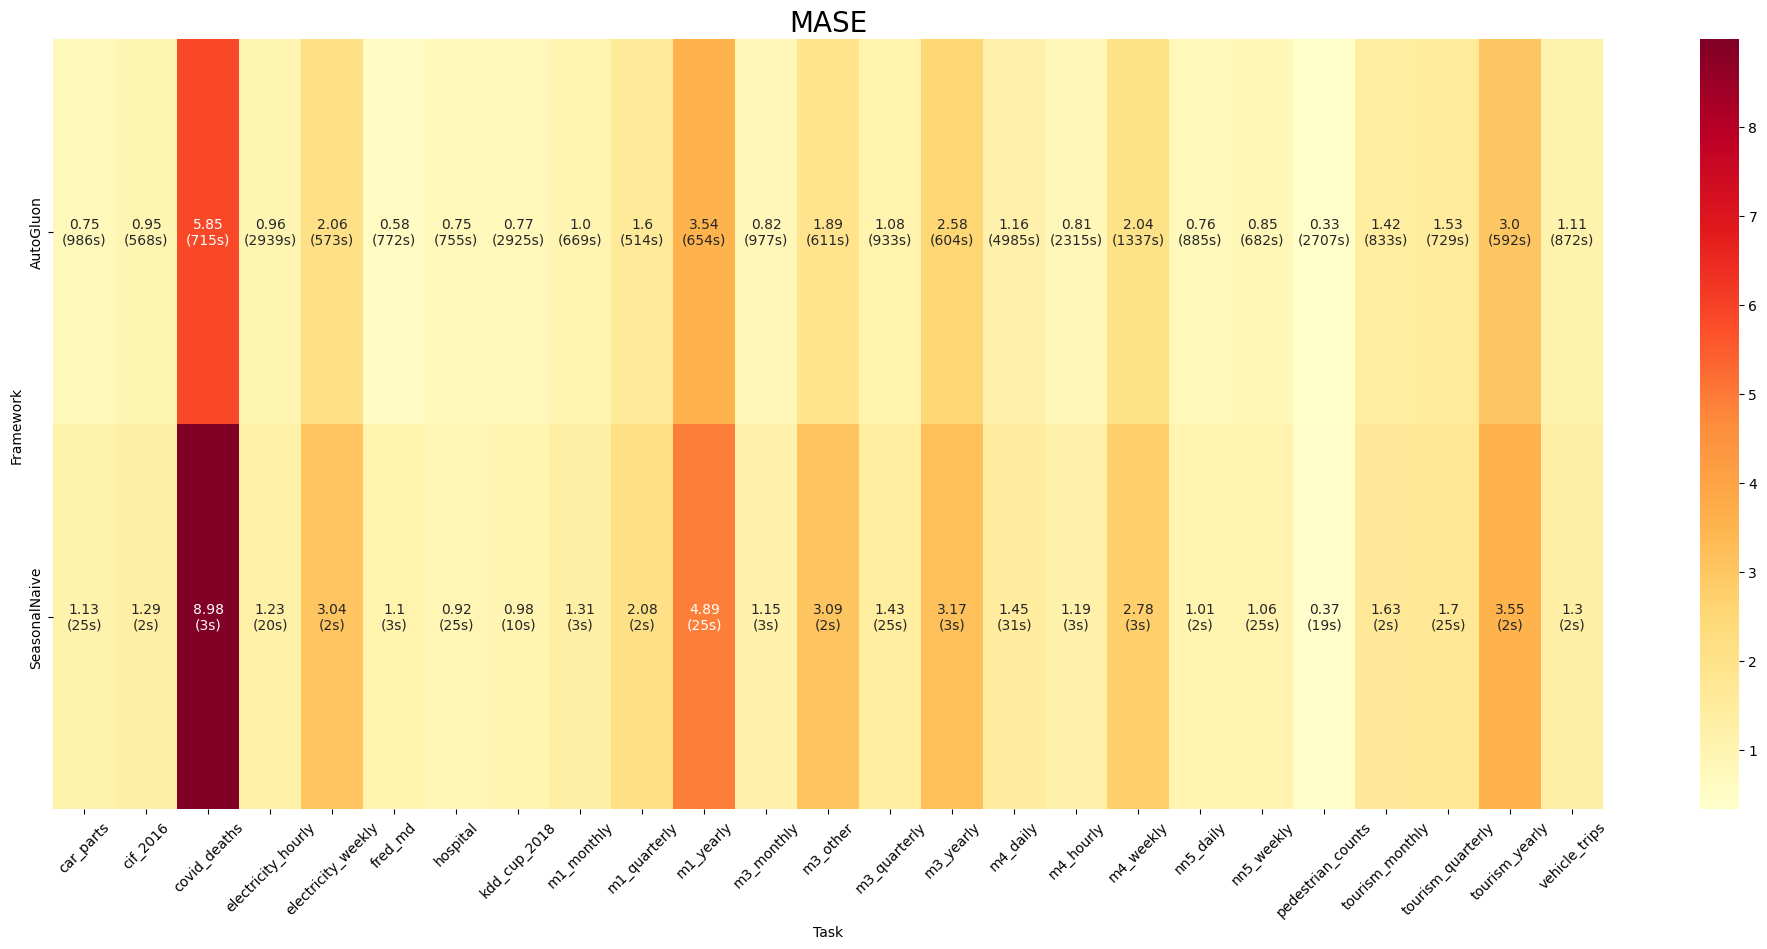

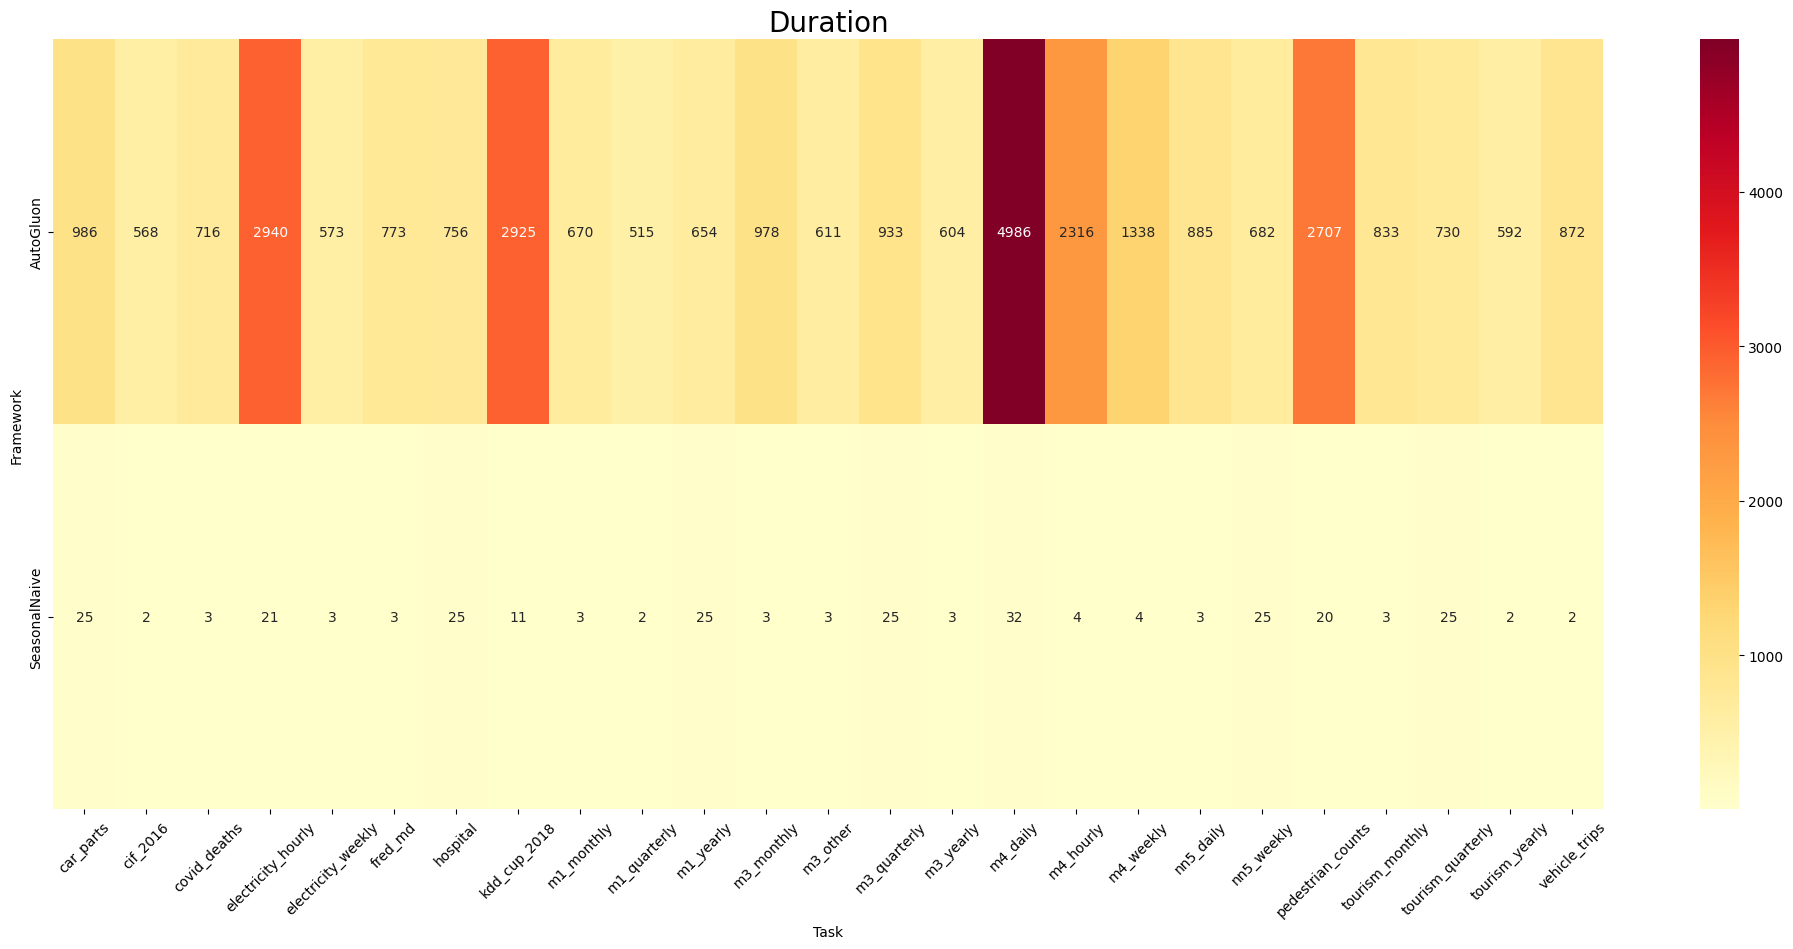

In [201]:
import numpy as np

# Get relevant columns only
df_rel = df_sorted[['framework', 'task', 'mase', 'wql', 'duration']]
df_rel = df_rel.drop_duplicates(subset=["framework", "task"], keep='first')

# Pivot the data and create a dataframe with random values
df_mase_pivot = df_rel.pivot(index='framework', columns='task', values='mase').astype(float).replace(float('inf'), float('nan'))
df_random_pivot = pd.DataFrame(np.random.rand(*df_mase_pivot.shape), index=df_mase_pivot.index, columns=df_mase_pivot.columns)

# Customized annotation (each cell should be value of mase and total duration as a subtext)
df_duration = df_rel.pivot(index='framework', columns='task', values='duration').replace([float('inf'), np.nan], np.nan).astype(float)
df_mase_annot = df_mase_pivot.round(2).astype(str) + "\n(" + df_duration.fillna(-1).astype(int).astype(str) + "s)"


# Example usage with MASE data
plot_heatmap(df_mase_pivot, "MASE", "Task", "Framework", annot=df_mase_annot, annot_format="s")

# Example usage with Duration data
plot_heatmap(df_duration, "Duration", "Task", "Framework")


### Normalized MASE (for Point Forecasting)

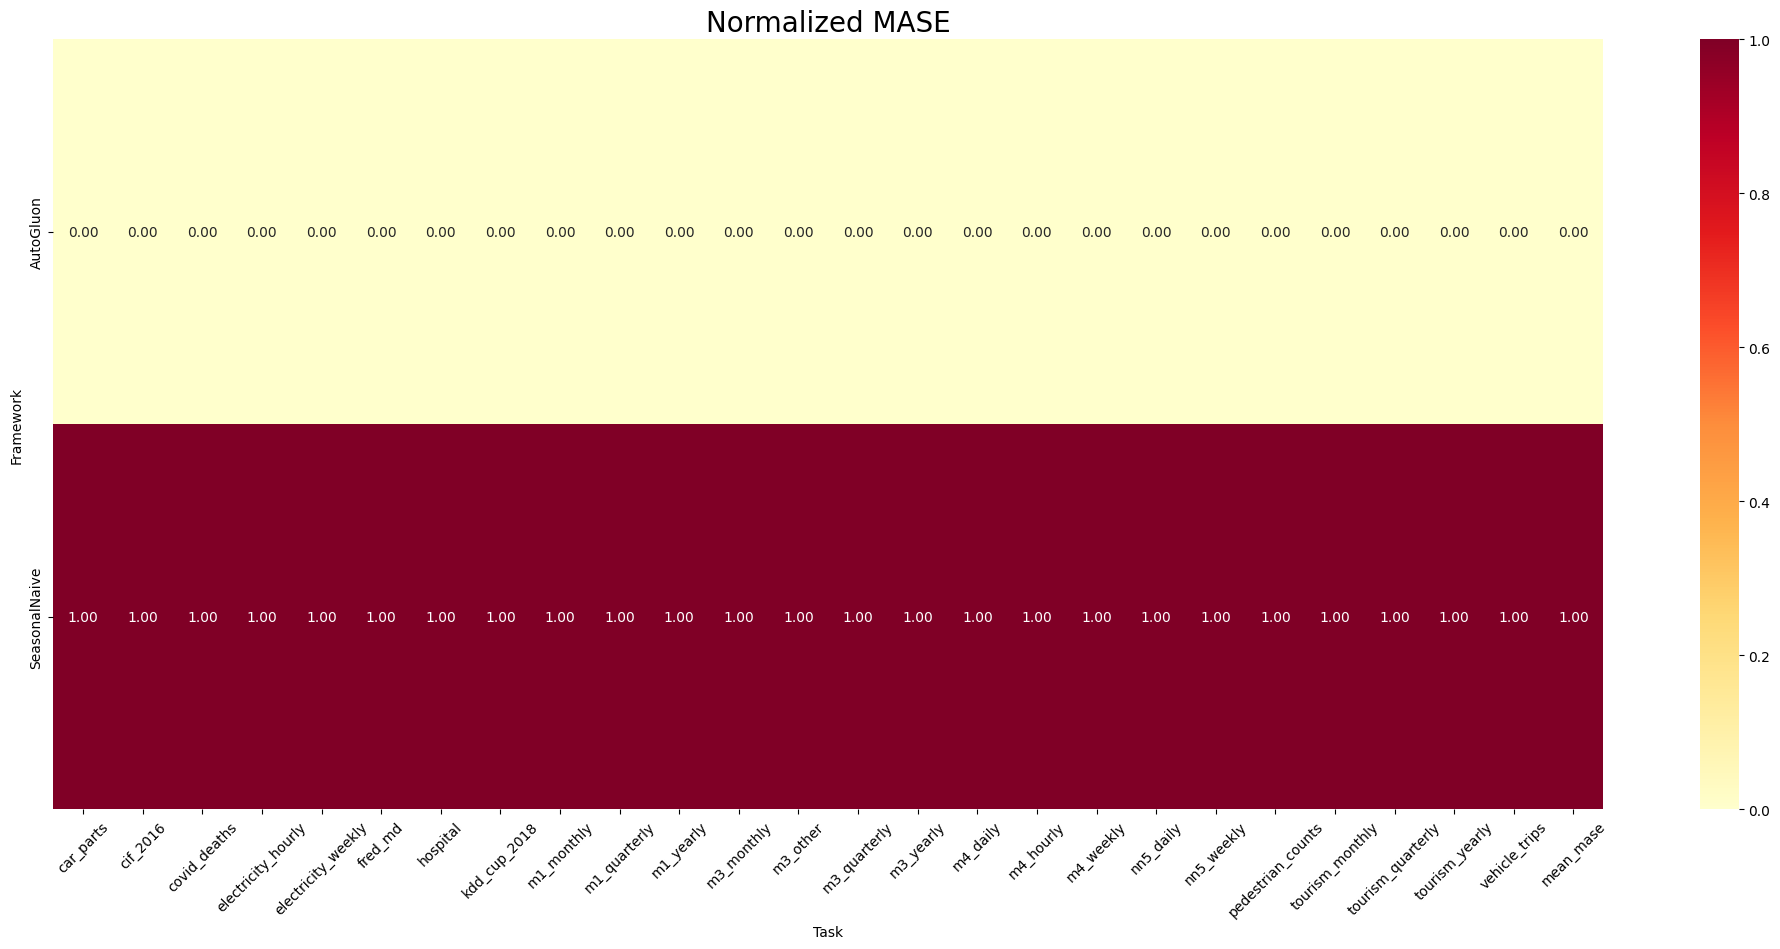

In [202]:
df_mase_pivot_scaled = df_mase_pivot.apply(min_max_scaling, axis=0)
df_mase_pivot_scaled['mean_mase'] = df_mase_pivot_scaled.mean(axis=1)

plot_heatmap(df_mase_pivot_scaled, "Normalized MASE", "Task", "Framework", annot_format=".2f")


### Aggregated Metrics (for Point Forecasting)

In [203]:
calculate_framework_metrics(df_mase_pivot)

,average_rescaled_mase,average_rank,champion
framework,,,
AutoGluon,1.528766,1.0,25
SeasonalNaive,2.073030,2.0,0
